**Precessing the SCC data based on AIRR standards**

- AirrCell formats reference: [AirrCell](https://scirpy.scverse.org/en/latest/tutorials/tutorial_io.html#creating-anndata-objects-from-other-formats)

- data download: [GSE123813](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE123813)
- data reference: [SCC reference](https://www.nature.com/articles/s41591-019-0522-3)
- description: SCC dataset contains pre-treatment and post-treatment data of 11 BCC patients, with paired TCR and GEX sequencing data. Sorted the cell into different cell types and different T cell subtypes.

**Guideline (user-defined dataset)**:
1. read the data and construct AirrCells
2. use scirpy to get the adata
3. filter cells and genes, select hvgs (Scanpy pipeline, without scaling across cells)
4. index chains, chain_qc, filter chains and EDA with scirpy
5. define clonotype with scirpy
6. tokenize the chains with esm tokenizer

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
from pathlib import Path
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=70)
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)

**1. Read the data and construct the AirrCell**

In [2]:
import vqtcr as vq
path_base = '/mnt/d/Dataset/MrTCR/BCC/'
path_merged = path_base + 'scc_merged_airr.h5ad'

In [3]:
import pandas as pd
scc_tcell_meta = pd.read_csv(path_base+'GSE123813_scc_metadata.txt.gz', 
                           sep='\t', compression='gzip', index_col='cell.id')

In [4]:
scc_tcell_meta # useful info: patient, treatment and cluster

,patient,treatment,cluster,UMAP1,UMAP2
cell.id,,,,,
scc.su010.post_AAACCTGAGACAAAGG,su010,post,CD8_mem,-2.155080,1.904121
scc.su010.post_AAACCTGAGACTAAGT,su010,post,CD8_ex,-1.547080,-1.710866
scc.su010.post_AAACCTGAGGCATGGT,su010,post,CD8_mem,-0.820249,0.311856
scc.su010.post_AAACCTGAGGGTCGAT,su010,post,Naive,2.743202,0.647236
scc.su010.post_AAACCTGAGGTACTCT,su010,post,Tfh,2.759312,0.526145
...,...,...,...,...,...
scc.su014.pre_TTTGTCAAGTGTTGAA,su014,pre,Th17,2.970795,-5.863445
scc.su014.pre_TTTGTCACAAATACAG,su014,pre,Th17,1.954126,-6.320317
scc.su014.pre_TTTGTCAGTCTAACGT,su014,pre,CD8_eff,-5.906037,-0.211607


In [5]:
scc_tcell_meta['patient'].value_counts()

patient
su010    10475
su011     7552
su013     4557
su014     3432
Name: count, dtype: int64

In [6]:
df_gex = pd.read_csv(path_base+'GSE123813_scc_scRNA_counts.txt.gz', sep="\t", index_col=0)
df_gex.head()   # gene expression counts

,scc.su010.pre.rep1_AAACCTGCATGTTCCC,scc.su010.pre.rep1_AAACGGGAGGACAGAA,scc.su010.pre.rep1_AAACGGGCAAGTCTAC,scc.su010.pre.rep1_AAACGGGGTAGTACCT,scc.su010.pre.rep1_AAACGGGGTGATAAAC,scc.su010.pre.rep1_AAACGGGTCAAAGTAG,scc.su010.pre.rep1_AAAGATGAGCTAACAA,scc.su010.pre.rep1_AAAGATGAGTGGCACA,scc.su010.pre.rep1_AAAGATGGTATATCCG,scc.su010.pre.rep1_AAAGCAAAGGGAAACA,...,scc.su014.post_TTGCCGTCACGGCGTT,scc.su014.post_TTGCCGTCAGATCCAT,scc.su014.post_TTGTAGGCAATGTTGC,scc.su014.post_TTTACTGCAGCTTCGG,scc.su014.post_TTTACTGGTGTGACGA,scc.su014.post_TTTACTGTCACTCCTG,scc.su014.post_TTTCCTCCATCGGAAG,scc.su014.post_TTTGCGCTCAAACCGT,scc.su014.post_TTTGGTTTCTTTACGT,scc.su014.post_TTTGTCATCATGCAAC
RP11-34P13.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FO538757.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FO538757.2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
AP006222.2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP4-669L17.10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import scipy.sparse as sp
X = sp.csr_matrix(df_gex.values.T)
var = pd.DataFrame(index=df_gex.index)
obs = pd.DataFrame(index=df_gex.columns)

In [8]:
adata_gex = sc.AnnData(X=X, obs=obs, var=var)
adata_gex

AnnData object with n_obs × n_vars = 26016 × 18347

In [9]:
df_tcr = pd.read_csv(path_base+'GSE123813_scc_tcr.txt.gz', sep="\t" , index_col=0)
df_tcr  # tcr infomation

,cdr3s_nt,cdr3s_aa
scc.su010.pre.rep1_AAACGGGAGGACAGAA,TRB:TGTGCCAGCAGCCAAGAGGCGAATGAGCAGTTCTTC,TRB:CASSQEANEQFF
scc.su010.pre.rep1_AAACGGGGTAGTACCT,TRB:TGTGCCAGCAGTTTACCTCGTTTTCTAGCCCACGACAATGAG...,TRB:CASSLPRFLAHDNEQFF
scc.su010.pre.rep1_AAACGGGGTGATAAAC,TRB:TGTGCCAGCAGCTTAGCCGCGGGCCGGGACAGTTTCCTTCTT...,TRB:CASSLAAGRDSFLLGANTGELFF
scc.su010.pre.rep1_AAACGGGTCAAAGTAG,TRA:TGTGCAGGTGAGAAAAGCAGCGGAGACAAGCTGACTTTT;TR...,TRA:CAGEKSSGDKLTF;TRA:CAVGSNAGGTSYGKLTF;TRB:CA...
scc.su010.pre.rep1_AAAGATGAGCTAACAA,TRA:TGTGCTGTGGACAACTCTGGGGCTGGGAGTTACCAACTCACTTTC,TRA:CAVDNSGAGSYQLTF
...,...,...
scc.su013.pre_TTTCCTCGTCCATGAT,TRA:TGTGCCGTGACGACGATGATGAGGGATAGCAGCTATAAATTG...,TRA:CAVTTMMRDSSYKLIF;TRB:CASSLDSYEQYF
scc.su013.pre_TTTGCGCGTTGTCTTT,TRA:TGTGCCGTGACGACGATGATGAGGGATAGCAGCTATAAATTG...,TRA:CAVTTMMRDSSYKLIF;TRB:CASSLDSYEQYF
scc.su013.pre_TTTGTCACACGGTAAG,TRA:TGTGCCGTGACGACGATGATGAGGGATAGCAGCTATAAATTG...,TRA:CAVTTMMRDSSYKLIF;TRB:CASSLDSYEQYF
scc.su013.post_CCTACACTCTGAGGGA,TRA:TGTGCCGTGACGACGATGATGAGGGATAGCAGCTATAAATTG...,TRA:CAVTTMMRDSSYKLIF;TRB:CASSLDSYEQYF


In [10]:
tcell_meta = scc_tcell_meta.join(df_tcr, how='inner')
tcell_meta # concat meta and tcr seq

,patient,treatment,cluster,UMAP1,UMAP2,cdr3s_nt,cdr3s_aa
scc.su010.post_AAACCTGAGACAAAGG,su010,post,CD8_mem,-2.155080,1.904121,TRA:TGTGCTCTGAGTCTGAACACAGGCTTTCAGAAACTTGTATTT...,TRA:CALSLNTGFQKLVF;TRB:CASSQGQGAAGELFF
scc.su010.post_AAACCTGAGACTAAGT,su010,post,CD8_ex,-1.547080,-1.710866,TRB:TGCGCCAGCAGGAGGATACTAGCGGGGGGTCCCGAGGGTACG...,TRB:CASRRILAGGPEGTQYF
scc.su010.post_AAACCTGAGGCATGGT,su010,post,CD8_mem,-0.820249,0.311856,TRA:TGTGCTCTGAGTCTGAACACAGGCTTTCAGAAACTTGTATTT...,TRA:CALSLNTGFQKLVF;TRB:CASSQGQGAAGELFF
scc.su010.post_AAACCTGAGGGTCGAT,su010,post,Naive,2.743202,0.647236,TRA:TGTGCTGTGAGTCACCCAACTCAGGGCGGATCTGAAAAGCTG...,TRA:CAVSHPTQGGSEKLVF;TRB:CASRGTGRYEQYF
scc.su010.post_AAACCTGAGGTACTCT,su010,post,Tfh,2.759312,0.526145,TRA:TGTGCTGTGAGGCAGGATCAAACTGGGGCAAACAACCTCTTC...,TRA:CAVRQDQTGANNLFF;TRB:CASSLKGSFHHEQYF
...,...,...,...,...,...,...,...
scc.su014.pre_TTTGTCAAGTGTTGAA,su014,pre,Th17,2.970795,-5.863445,TRA:TGTGCTGTGGGGAACAATGACATGCGCTTT;TRB:TGCGCCA...,TRA:CAVGNNDMRF;TRB:CASSLAQGAGANVLTF
scc.su014.pre_TTTGTCACAAATACAG,su014,pre,Th17,1.954126,-6.320317,TRA:TGTGCTTTCATGAAGCAGGCTACTGCCAGTAAACTCACCTTT...,TRA:CAFMKQATASKLTF;TRB:CASSLWAGEGQPQHF
scc.su014.pre_TTTGTCAGTCTAACGT,su014,pre,CD8_eff,-5.906037,-0.211607,TRA:TGTGCTACGGTCACTACTGGAGCCAATAGTAAGCTGACATTT...,TRA:CATVTTGANSKLTF;TRB:CASSLEAASSYNEQFF
scc.su014.pre_TTTGTCAGTTCAGTAC,su014,pre,Treg,7.109564,2.610217,TRA:TGTGCTACGGCGGGTTCTGCAAGGCAACTGACCTTT;TRB:T...,TRA:CATAGSARQLTF;TRB:CASSLSVSTDTQYF


In [11]:
common = adata_gex.obs_names.intersection(tcell_meta.index.astype(str))
adata_tmp = adata_gex[common].copy()
adata_tmp

AnnData object with n_obs × n_vars = 23122 × 18347

In [12]:
adata_tmp.obs = adata_tmp.obs.join(tcell_meta.loc[common], how="left")
adata_tmp

AnnData object with n_obs × n_vars = 23122 × 18347
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa'

In [13]:
sc.pp.filter_genes(adata_tmp, min_counts=1)
adata_tmp

filtered out 319 genes that are detected in less than 1 counts


AnnData object with n_obs × n_vars = 23122 × 18028
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'

In [14]:
tcell_meta = tcell_meta.reset_index(names='cell_id')

In [15]:
def _split_locus_seq(s):
    if pd.isna(s) or not isinstance(s, str) or s.strip() == "":
        return []
    out = []
    for p in s.split(";"):
        p = p.strip()
        if not p:
            continue
        if ':' in p:
            locus, seq = p.split(':', 1)
            locus = locus.strip().upper()
            seq = seq.strip()
            if locus in {'TRA', 'TRB'} and seq:
                out.append((locus, seq))
    return out

def build_airr_cells(tcell_meta, cell_col="cell_id", aa_col="cdr3s_aa", nt_col="cdr3s_nt"):
    airr_cells = []
    for _, row in tcell_meta.iterrows():
        cid = str(row[cell_col])
        cell = ir.io.AirrCell(cell_id=cid)
        aa_pairs = _split_locus_seq(row.get(aa_col, np.nan))
        nt_pairs = _split_locus_seq(row.get(nt_col, np.nan))
        aa_map = {"TRA": [], "TRB": []}
        nt_map = {"TRA": [], "TRB": []}
        for locus, seq in aa_pairs:
            aa_map[locus].append(seq)
        for locus, seq in nt_pairs:
            nt_map[locus].append(seq)
        for locus in ("TRA", "TRB"):
            n = max(len(aa_map[locus]), len(nt_map[locus]))
            for i in range(n):
                ch = ir.io.AirrCell.empty_chain_dict()  
                ch.update({
                    "locus": locus,   
                    "junction_aa": aa_map[locus][i] if i < len(aa_map[locus]) else np.nan,
                    "junction":    nt_map[locus][i] if i < len(nt_map[locus]) else np.nan,
                    # optional
                    "productive": True,         
                    "umi_count":  np.nan,
                    "v_call":     np.nan,
                    "j_call":     np.nan,
                    "d_call":     np.nan,
                })
                if pd.isna(ch["junction_aa"]) and pd.isna(ch["junction"]):
                    continue
                cell.add_chain(ch)

        airr_cells.append(cell)
    return airr_cells

In [16]:
cells = build_airr_cells(tcell_meta)
len(cells)

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


23122

**2. use scirpy to get the adata**

In [17]:
adata_airr = ir.io.from_airr_cells(cells)

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


In [18]:
barcode2idx = {barcode: i for i, barcode in enumerate(adata_airr.obs_names)}
idx = [barcode2idx.get(barcode) for barcode in adata_tmp.obs_names]

adata_tmp.obsm['airr'] = adata_airr.obsm['airr'][idx]
adata_tmp

AnnData object with n_obs × n_vars = 23122 × 18028
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'
    obsm: 'airr'

**3. filter cells and genes, select hvgs**

In [19]:
import awkward as ak
adata_tmp = adata_tmp[~ak.is_none(adata_tmp.obsm['airr']).to_numpy()]
adata_tmp

View of AnnData object with n_obs × n_vars = 23122 × 18028
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts'
    obsm: 'airr'

In [20]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)
sc.pp.log1p(adata_tmp)
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000)
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
adata_tmp

/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 23122 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'airr'

**4. index chains, chain_qc, filter chains and EDA with scirpy**

In [21]:
ir.pp.index_chains(adata_tmp)
ir.tl.chain_qc(adata_tmp)
adata_tmp

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


/home/zl/anaconda3/envs/airr/lib/python3.10/site-packages/scirpy/pp/_index_chains.py:142: ImplicitModificationWarning: Setting element `.obsm['chain_indices']` of view, initializing view as actual.
  params.adata.obsm[key_added] = ak.zip(res, depth_limit=1)  # type: ignore


Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.


AnnData object with n_obs × n_vars = 23122 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices'
    obsm: 'airr', 'chain_indices'

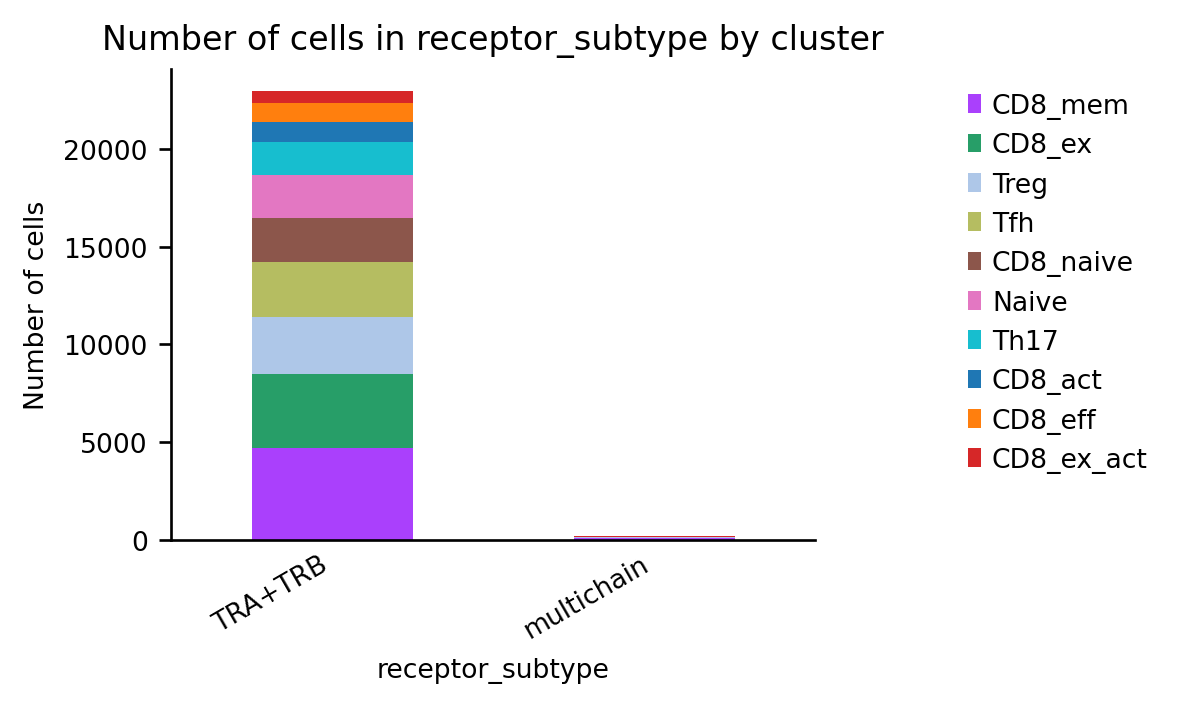

In [22]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="cluster")

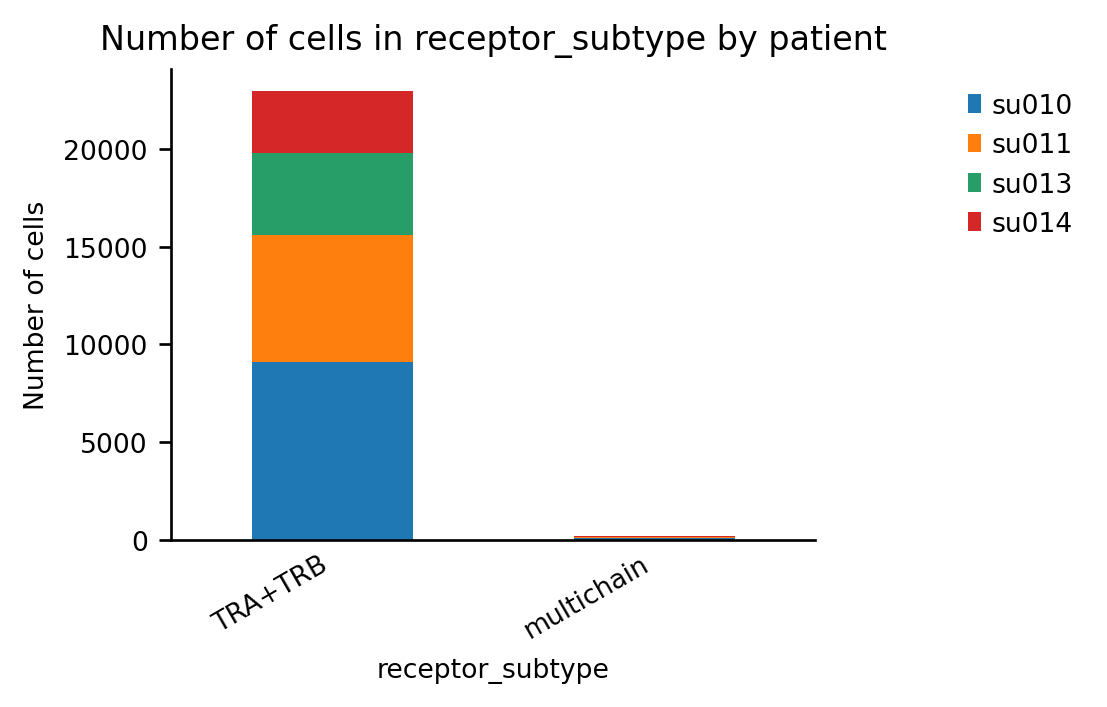

In [23]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="patient")

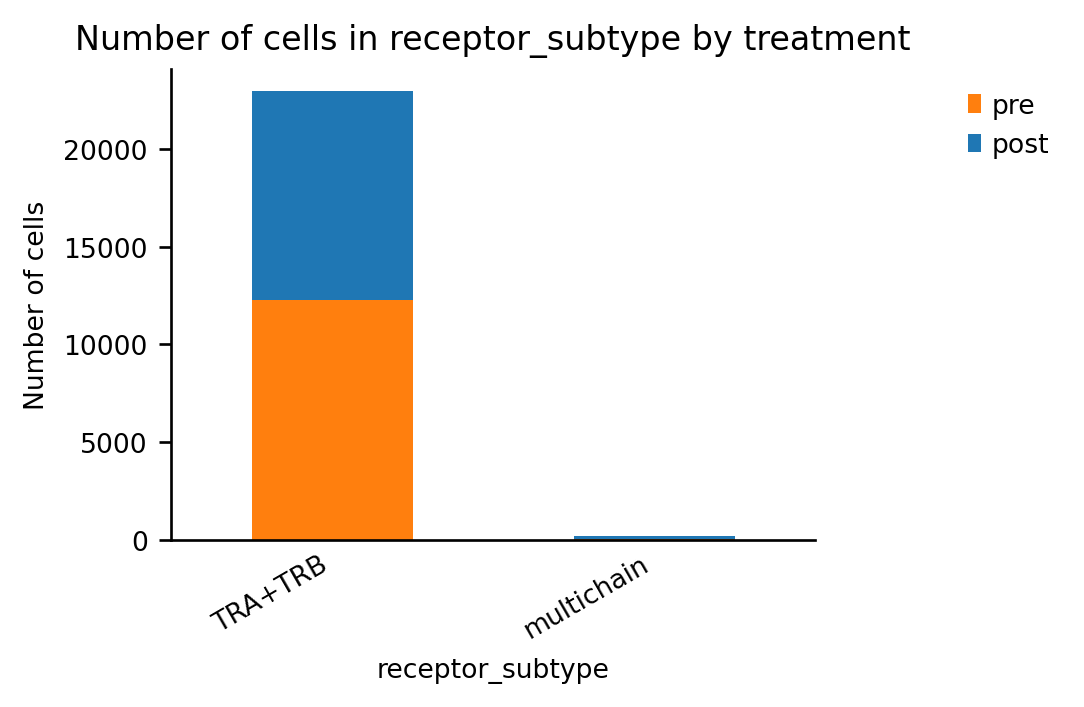

In [24]:
_ = ir.pl.group_abundance(adata_tmp, groupby="receptor_subtype", target_col="treatment")

In [25]:
adata_tmp.obs.cluster.value_counts()
adata_tmp.obs.treatment.value_counts()
pd.crosstab(adata_tmp.obs["cluster"], adata_tmp.obs["treatment"])

treatment,post,pre
cluster,,
CD8_act,782,286
CD8_eff,102,849
CD8_ex,2409,1411
CD8_ex_act,9,596
CD8_mem,3673,1110
CD8_naive,143,2098
Naive,884,1324
Tfh,1872,988
Th17,297,1370


In [26]:
adata_tmp.obs["chain_pairing"].value_counts()

chain_pairing
single pair        14820
orphan VDJ          4829
extra VDJ           1024
orphan VJ            998
extra VJ             808
two full chains      483
multichain           160
Name: count, dtype: int64

In [27]:
adata_tmp = adata_tmp[adata_tmp.obs["chain_pairing"] == "single pair", :]
adata_tmp

View of AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_colors', 'patient_colors', 'treatment_colors'
    obsm: 'airr', 'chain_indices'

**5. define clonotype with scirpy**
- prepare `.obs` with clonetype, clone_id, alpha chain, beta chain, antigen...

In [28]:
adata = adata_tmp.copy()

In [29]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, key_added='clonotype', receptor_arms='all', dual_ir='primary_only')
adata

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 


--> Done initializing lookup tables. (0:00:00)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `adata.obs["clonotype"]`.
Stored result in `adata.obs["clonotype_size"]`.


AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_colors', 'patient_colors', 'treatment_colors', 'ir_dist_nt_identity', 'clonotype'
    obsm: 'airr', 'chain_indices'

In [30]:
adata.obs["clonotype"].value_counts()

clonotype
11      563
3463    486
4820    394
16      370
1       267
       ... 
5506      1
5536      1
14        1
12        1
10        1
Name: count, Length: 5554, dtype: int64

**6. tokenize the chains with esm tokenizer**

In [31]:
junction_aa = ir.get.airr(adata, 'junction_aa')
junction_aa

,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa
scc.su010.pre.rep1_AAACGGGCAAGTCTAC,CAVSDGGGFKTIF,CASSPRKKTGVTTDTQYF,None,None
scc.su010.pre.rep1_AAAGATGAGTGGCACA,CALSEADFGNEKLTF,CASSLGTVNTEAFF,None,None
scc.su010.pre.rep1_AAAGATGGTATATCCG,CAAELSGGGADGLTF,CASSPRDSNSPLHF,None,None
scc.su010.pre.rep1_AAAGTAGAGGACATTA,CAASMGGTASKLTF,CSTRTGGGNTIYF,None,None
scc.su010.pre.rep1_AAAGTAGTCGCCCTTA,CALSEFIKAAGNKLTF,CASSYWGSSGTNYNEQFF,None,None
...,...,...,...,...
scc.su014.post_TTGCCGTCAGATCCAT,CATAGSARQLTF,CASSLSVSTDTQYF,None,None
scc.su014.post_TTTACTGTCACTCCTG,CAETDLGGYNKLIF,CASSLGLAGGGQETQYF,None,None
scc.su014.post_TTTGCGCTCAAACCGT,CAMKLTGGGNKLTF,CASSLTGDEQFF,None,None
scc.su014.post_TTTGGTTTCTTTACGT,CAVLLGAGGSYIPTF,CASSSEELGLNYGYTF,None,None


In [32]:
adata.obs['VJ_1_junction_aa'] = junction_aa['VJ_1_junction_aa']
adata.obs['VDJ_1_junction_aa'] = junction_aa['VDJ_1_junction_aa']
adata.obs['VJ_1_junction_aa'], adata.obs['VDJ_1_junction_aa']

(scc.su010.pre.rep1_AAACGGGCAAGTCTAC       CAVSDGGGFKTIF
 scc.su010.pre.rep1_AAAGATGAGTGGCACA     CALSEADFGNEKLTF
 scc.su010.pre.rep1_AAAGATGGTATATCCG     CAAELSGGGADGLTF
 scc.su010.pre.rep1_AAAGTAGAGGACATTA      CAASMGGTASKLTF
 scc.su010.pre.rep1_AAAGTAGTCGCCCTTA    CALSEFIKAAGNKLTF
                                              ...       
 scc.su014.post_TTGCCGTCAGATCCAT            CATAGSARQLTF
 scc.su014.post_TTTACTGTCACTCCTG          CAETDLGGYNKLIF
 scc.su014.post_TTTGCGCTCAAACCGT          CAMKLTGGGNKLTF
 scc.su014.post_TTTGGTTTCTTTACGT         CAVLLGAGGSYIPTF
 scc.su014.post_TTTGTCATCATGCAAC            CAVSDSNYQLIW
 Name: VJ_1_junction_aa, Length: 14820, dtype: object,
 scc.su010.pre.rep1_AAACGGGCAAGTCTAC    CASSPRKKTGVTTDTQYF
 scc.su010.pre.rep1_AAAGATGAGTGGCACA        CASSLGTVNTEAFF
 scc.su010.pre.rep1_AAAGATGGTATATCCG        CASSPRDSNSPLHF
 scc.su010.pre.rep1_AAAGTAGAGGACATTA         CSTRTGGGNTIYF
 scc.su010.pre.rep1_AAAGTAGTCGCCCTTA    CASSYWGSSGTNYNEQFF
                       

In [33]:
adata.obs['alpha_len'] = junction_aa.VJ_1_junction_aa.str.len().values
adata.obs['beta_len'] = junction_aa.VDJ_1_junction_aa.str.len().values
len_alpha = junction_aa.VJ_1_junction_aa.str.len().max()
len_beta = junction_aa.VDJ_1_junction_aa.str.len().max()
pad_len = max(len_alpha, len_beta)
len_alpha, len_beta, pad_len

(np.int64(27), np.int64(23), np.int64(27))

In [34]:
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VJ_1_junction_aa',
                label_col='alpha_seq',
                length_col='alpha_len', 
                mask_col='alpha_mask', 
                pad=pad_len, 
                add_special_tokens=False)
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VDJ_1_junction_aa',
                label_col='beta_seq',
                length_col='beta_len', 
                mask_col='beta_mask', 
                pad=pad_len, 
                add_special_tokens=False)
adata

AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'chain_indices', 'cluster_colors', 'patient_colors', 'treatment_colors', 'ir_dist_nt_identity', 'clonotype'
    obsm: 'airr', 'chain_indices', 'alpha_seq', 'alpha_mask', 'beta_seq', 'beta_mask'

- save to `h5ad` file

In [35]:
adata.write_h5ad(path_merged, compression='gzip')

In [36]:
vdjdb = ir.datasets.vdjdb()

Processing VDJDB entries:   0%|          | 0/110573 [00:00<?, ?it/s]

Converting to AnnData object
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array


In [37]:
ir.pp.ir_dist(adata, vdjdb, metric="identity", sequence="aa")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.


In [38]:
ir.tl.ir_query(
    adata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:03)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored IR distance matrix in `adata.uns["ir_query_VDJDB_aa_identity"]`.


In [56]:
df=ir.tl.ir_query_annotate_df(
    adata,
    vdjdb,
    metric="identity",
    sequence="aa",
    # include_ref_cols=["antigen.species", "antigen.gene"],
)

In [85]:
df

,antigen.epitope,antigen.gene,antigen.species,meta.cell.subset,meta.clone.id,meta.donor.MHC,meta.donor.MHC.method,meta.epitope.id,meta.replica.id,meta.structure.id,...,method.frequency,method.identification,method.sequencing,method.singlecell,method.verification,mhc.a,mhc.b,mhc.class,reference.id,species
scc.su010.pre.rep1_AACCATGCAAGGTTTC,GILGFVFTL,M,InfluenzaA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/11684,dextramer-sort,rna-seq,yes,NaN,HLA-A*02:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens
scc.su010.pre.rep1_AACCATGCAAGGTTTC,KLGGALQAK,IE1,CMV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/25584,dextramer-sort,rna-seq,yes,NaN,HLA-A*03:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens
scc.su010.pre.rep1_AACTCTTAGCTGCAAG,NQKLIANQF,Spike,SARS-CoV-2,CD8+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,dextramer-sort,NaN,yes,NaN,HLA-B*15:01,B2M,MHCI,PMID:35383307,HomoSapiens
scc.su010.pre.rep1_AACTGGTTCATTCACT,PKYVKQNTLKLAT,HA,InfluenzaA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/133,tetramer-sort,amplicon-seq,yes,NaN,HLA-DRA*01:01,HLA-DRB1*04:01,MHCII,PMID:28636589,HomoSapiens
scc.su010.pre.rep1_AAGCCGCTCCGCTGTT,TTDPSFLGRY,ORF1ab,SARS-CoV-2,CD8+,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,dextramer-sort,NaN,yes,NaN,HLA-A*01:01,B2M,MHCI,PMID:35383307,HomoSapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc.su014.post_TTTGTCATCATGCAAC,KLGGALQAK,IE1,CMV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/25584,dextramer-sort,rna-seq,yes,NaN,HLA-A*03:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens
scc.su014.post_TTTGTCATCATGCAAC,KLGGALQAK,IE1,CMV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/25584,dextramer-sort,rna-seq,yes,NaN,HLA-A*03:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens
scc.su014.post_TTTGTCATCATGCAAC,RLRAEAQVK,EBNA3A,EBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/25584,dextramer-sort,rna-seq,yes,NaN,HLA-A*03:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens
scc.su014.post_TTTGTCATCATGCAAC,AVFDRKSDAK,EBNA3B,EBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1/25584,dextramer-sort,rna-seq,yes,NaN,HLA-A*11:01,B2M,MHCI,https://www.10xgenomics.com/resources/applicat...,HomoSapiens


In [64]:
df['antigen.epitope'].value_counts()

antigen.epitope
KLGGALQAK     5365
GILGFVFTL     2262
KRWIILGLNK    1948
AVFDRKSDAK     773
RAKFKQLL       685
              ... 
IMDQVPFWV        0
IMDQVPFVV        0
IMDQVPFTV        0
IMDQVPFSV        0
IMDQVQFSV        0
Name: count, Length: 1771, dtype: int64

In [59]:
ir.tl.ir_query_annotate(
    adata,
    vdjdb,
    metric="identity",
    sequence="aa",
    # include_ref_cols=["antigen.species", "antigen.gene"],
    strategy="most-frequent",
)

  0%|          | 0/56784 [00:00<?, ?it/s]

Stored result in `adata.obs["antigen.epitope"]`.
Stored result in `adata.obs["antigen.gene"]`.
Stored result in `adata.obs["antigen.species"]`.
Stored result in `adata.obs["meta.cell.subset"]`.
Stored result in `adata.obs["meta.clone.id"]`.
Stored result in `adata.obs["meta.donor.MHC"]`.
Stored result in `adata.obs["meta.donor.MHC.method"]`.
Stored result in `adata.obs["meta.epitope.id"]`.
Stored result in `adata.obs["meta.replica.id"]`.
Stored result in `adata.obs["meta.structure.id"]`.
Stored result in `adata.obs["meta.study.id"]`.
Stored result in `adata.obs["meta.subject.cohort"]`.
Stored result in `adata.obs["meta.subject.id"]`.
Stored result in `adata.obs["meta.tissue"]`.
Stored result in `adata.obs["method.frequency"]`.
Stored result in `adata.obs["method.identification"]`.
Stored result in `adata.obs["method.sequencing"]`.
Stored result in `adata.obs["method.singlecell"]`.
Stored result in `adata.obs["method.verification"]`.
Stored result in `adata.obs["mhc.a"]`.
Stored result 

In [84]:
adata.obs

,patient,treatment,cluster,UMAP1,UMAP2,cdr3s_nt,cdr3s_aa,receptor_type,receptor_subtype,chain_pairing,...,method.frequency,method.identification,method.sequencing,method.singlecell,method.verification,mhc.a,mhc.b,mhc.class,reference.id,species
scc.su010.pre.rep1_AAACGGGCAAGTCTAC,su010,pre,Th17,2.955230,-4.796993,TRA:TGTGCTGTGAGTGACGGTGGAGGCTTCAAAACTATCTTT;TR...,TRA:CAVSDGGGFKTIF;TRB:CASSPRKKTGVTTDTQYF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su010.pre.rep1_AAAGATGAGTGGCACA,su010,pre,CD8_naive,-4.367948,2.880905,TRA:TGTGCTCTGAGTGAGGCGGACTTTGGAAATGAGAAATTAACC...,TRA:CALSEADFGNEKLTF;TRB:CASSLGTVNTEAFF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su010.pre.rep1_AAAGATGGTATATCCG,su010,pre,CD8_naive,2.746689,-0.875175,TRA:TGTGCCGCGGAGCTCTCAGGAGGAGGTGCTGACGGACTCACC...,TRA:CAAELSGGGADGLTF;TRB:CASSPRDSNSPLHF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su010.pre.rep1_AAAGTAGAGGACATTA,su010,pre,CD8_naive,3.975677,-0.934265,TRA:TGTGCAGCAAGTATGGGCGGCACTGCCAGTAAACTCACCTTT...,TRA:CAASMGGTASKLTF;TRB:CSTRTGGGNTIYF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su010.pre.rep1_AAAGTAGTCGCCCTTA,su010,pre,CD8_naive,-4.752193,2.280480,TRA:TGTGCTCTGAGTGAGTTCATCAAAGCTGCAGGCAACAAGCTA...,TRA:CALSEFIKAAGNKLTF;TRB:CASSYWGSSGTNYNEQFF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc.su014.post_TTGCCGTCAGATCCAT,su014,post,Treg,7.368882,2.825577,TRA:TGTGCTACGGCGGGTTCTGCAAGGCAACTGACCTTT;TRB:T...,TRA:CATAGSARQLTF;TRB:CASSLSVSTDTQYF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su014.post_TTTACTGTCACTCCTG,su014,post,CD8_eff,-5.676641,-0.858432,TRA:TGTGCAGAGACTGACCTTGGTGGCTACAATAAGCTGATTTTT...,TRA:CAETDLGGYNKLIF;TRB:CASSLGLAGGGQETQYF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su014.post_TTTGCGCTCAAACCGT,su014,post,Th17,2.333773,-5.540516,TRA:TGTGCAATGAAACTCACGGGAGGAGGAAACAAACTCACCTTT...,TRA:CAMKLTGGGNKLTF;TRB:CASSLTGDEQFF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scc.su014.post_TTTGGTTTCTTTACGT,su014,post,CD8_mem,-5.674574,-0.213086,TRA:TGTGCTGTGCTGTTAGGGGCAGGAGGAAGCTACATACCTACA...,TRA:CAVLLGAGGSYIPTF;TRB:CASSSEELGLNYGYTF,TCR,TRA+TRB,single pair,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
adata.obs['antigen.epitope'].value_counts()

antigen.epitope
KLGGALQAK     924
KRWIILGLNK    487
ambiguous     343
GILGFVFTL     127
NLVPMVATV      77
             ... 
YAYAKWKL        1
LSFKELLVY       1
FPNITNLCP       1
KVLEYVIKV       1
SSLENFRAYV      1
Name: count, Length: 104, dtype: int64